In [6]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis

### Build basis and Hamiltonian

In [7]:
Nsites = 4
Nbosons = 4
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [8]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis


def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'


def isodd(n):
    return int(n) % 2 == True


def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)


def gaugeFixedBasis(Nsites, Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons + 1) ** Nsites):
        bosonString = np.base_repr(number, base=Nbosons + 1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state) - 1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0:  # For the first site
                thislink = '-' * (isodd(thisn)) + '+' * (not isodd(thisn))
            else:  # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates


# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c, Nbosons):
    return basis(Nbosons + 1, int(c))


def linkState(c):
    if c == '+':
        return (basis(2, 0) + basis(2, 1)).unit()
    elif c == '-':
        return (basis(2, 0) - basis(2, 1)).unit()


basisStatesList = gaugeFixedBasis(Nsites, Nbosons)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList:  # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        if isodd(ind):
            basisVector.append(linkState(c))
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        if ind % 2 == 0:
            basisVector.append(siteState(c, Nbosons))

    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis), i) * fullBasis[i].dag()

P_sparse = P_gaugefixed.data

In [9]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
basis = tensor_basis(basis_spin, basis_boson)

### Build Hamiltonian and calculate ground state

In [13]:
# hop = [[-0.1, i, i, i + 1] for i in range(L_modes - 1)]
# # hop+=[[-1.0,L_modes-1,L_modes-1,0]]
# field = [[1, i] for i in range(L_spin)]


hop = [[-10, i, i, i + 1] for i in range(L_modes - 1)]
field = [[0, i] for i in range(L_spin)]

static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[1.11022302e-15] [-3.33066907e-16] [1.44328993e-15]
[0.00486833] [0.03256031] [0.06484576]


### Calculate string correlator

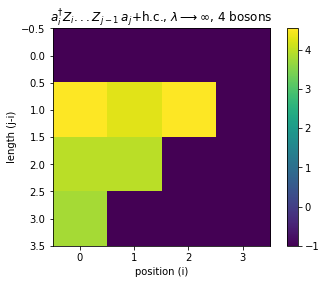

In [14]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(1,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe.T)#np.flip(resRe,0))
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
# plt.axis([-0.5, 4.5, 0.5, 5.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

In [12]:
hop=[[1.0,4,4,5]]
#hop=[[1.0,i,i,i+1] for i in range(L_modes-1)]
static=[["z|+-",hop],["z|-+",hop]]
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
correlator = P_sparse@correlator@P_sparse.T.conj()
H_expt = np.dot(psi0.T.conj(),correlator@psi0)
print(H_expt,E)

[[3.77031789+5.55111512e-17j]] [-75.40635775]


### Calculate pairing order parameter

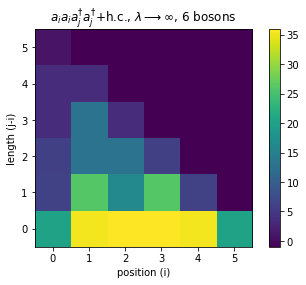

In [22]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, 5.5, -0.5, 5.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

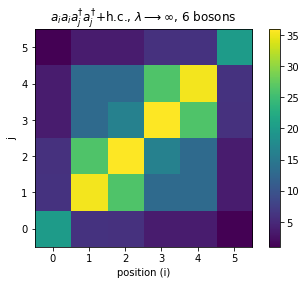

In [23]:
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("j")
plt.axis([-0.5, 5.5, -0.5, 5.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

In [46]:
hop=[[-20,i,i,i+1] for i in range(L_modes-1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[-0.0,i] for i in range(L_spin)]
static=[["z|+-",hop],["z|-+",hop],["x|",field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H = hamiltonian(static,[],basis=basis,**no_checks)
H_sparse = H.tocsr()
# Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
E,psi0 = eigsh(Hgaugefixed,k=1,which='SA')

##### Testing functions

In [97]:
for l in range(Nsites):
    for i in range(Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        print(hop)

[1.0, 0, 0]
[1.0, 0, 0, 1]
[1.0, 0, 1, 0, 2]
[1.0, 0, 1, 2, 0, 3]
[1.0, 1, 1]
[1.0, 1, 1, 2]
[1.0, 1, 2, 1, 3]
[1.0, 2, 2]
[1.0, 2, 2, 3]
[1.0, 3, 3]


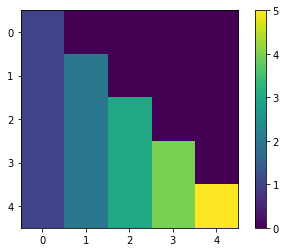

In [159]:
resli=np.zeros([Nsites,Nsites])
for l in range(Nsites):
    for i in range(Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        resli[l][i]=i

resli=np.delete(resli, 0, 1)

resli=np.delete(resli, -1, 0)

plt.imshow(np.flip(resli,0))
plt.colorbar()
plt.show()

In [9]:
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        print(pairing)

[1.0, 0, 0, 0, 0]
[1.0, 0, 0, 1, 1]
[1.0, 0, 0, 2, 2]
[1.0, 0, 0, 3, 3]
[1.0, 0, 0, 4, 4]
[1.0, 0, 0, 5, 5]
[1.0, 1, 1, 0, 0]
[1.0, 1, 1, 1, 1]
[1.0, 1, 1, 2, 2]
[1.0, 1, 1, 3, 3]
[1.0, 1, 1, 4, 4]
[1.0, 1, 1, 5, 5]
[1.0, 2, 2, 0, 0]
[1.0, 2, 2, 1, 1]
[1.0, 2, 2, 2, 2]
[1.0, 2, 2, 3, 3]
[1.0, 2, 2, 4, 4]
[1.0, 2, 2, 5, 5]
[1.0, 3, 3, 0, 0]
[1.0, 3, 3, 1, 1]
[1.0, 3, 3, 2, 2]
[1.0, 3, 3, 3, 3]
[1.0, 3, 3, 4, 4]
[1.0, 3, 3, 5, 5]
[1.0, 4, 4, 0, 0]
[1.0, 4, 4, 1, 1]
[1.0, 4, 4, 2, 2]
[1.0, 4, 4, 3, 3]
[1.0, 4, 4, 4, 4]
[1.0, 4, 4, 5, 5]
[1.0, 5, 5, 0, 0]
[1.0, 5, 5, 1, 1]
[1.0, 5, 5, 2, 2]
[1.0, 5, 5, 3, 3]
[1.0, 5, 5, 4, 4]
[1.0, 5, 5, 5, 5]


### Density

In [31]:
density=[[1.0,3]]
static=[["|n",density]]
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
correlator = hamiltonian(static,[],basis=basis,**no_checks)
H_expt = correlator.expt_value(psi1,time=0,check=True)
print(H_expt)

(2.752281739308086+4.440892098500626e-16j)


In [29]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,0]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi1,t,{"n":n})
O_n = Obs_t["n"]
print(O_n)

(1.999961590738686-2.0194839173657902e-28j)


/tmp/ipykernel_5400/3460746893.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,0]] ]],[],dtype=np.float64,**obs_args)
